In [1]:
from PIL import Image
from rl_benchmarks.models import iBOTViT
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import pathlib
from tqdm import tqdm
from PIL import Image
import numpy as np
Image.MAX_IMAGE_PIXELS = None
from torchvision import transforms
import torch
from torch.utils.data import Dataset
import os
from multiprocessing import Pool
import umap
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from rl_benchmarks.utils.linear_evaluation import get_binary_class_metrics, get_bootstrapped_metrics, dict_to_dataframe
import umap.plot

device = "cuda:0" if torch.cuda.is_available() else "cpu"
weights_path = '/home/yuxin/Downloads/ibot_vit_base_pancan.pth'
ibot_base_pancancer = iBOTViT(architecture="vit_base_pancan", encoder="student", weights_path=weights_path).to(device)

/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)
2024-03-28 11:07:51.096 | INFO     | rl_benchmarks.models.feature_extractors.ibot_vit:__init__:78 - Pretrained weights found at /home/yuxin/Downloads/ibot_vit_base_pancan.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['masked_embed', 'head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v', 'head.last_layer2.weight_g', 'head.last_layer2.weight_v'])


In [15]:
patch_size = 224
data_root = pathlib.Path('/mnt/hd0/project_large_files/bee/VTMA_v3')
cohorts = ['QDUH', 'SHSU', 'SUQH']
data_trans = transforms.Compose([
                                transforms.CenterCrop(patch_size*4),
                                transforms.Resize(patch_size),
                                ibot_base_pancancer.transform,
                                ])


In [16]:
for cohort in cohorts:
    cohort_root = data_root / cohort / 'imgs'
    tile_paths = list(cohort_root.glob('**/*.png'))
    for path in tqdm(tile_paths, desc=f'Processing {cohort}'):
        im = Image.open(path)
        tensor = data_trans(im)
        batch = tensor.unsqueeze(0)
        batch = batch.to(device)
        features = ibot_base_pancancer(batch).detach().cpu().numpy()
        save_path = data_root / cohort / 'features' / f'{path.stem}.npy' 
        save_path.parent.mkdir(exist_ok=True, parents=True)
        np.save(save_path, features)

Processing SUQH: 100%|██████████| 108/108 [00:56<00:00,  1.92it/s]


In [17]:
features = []
labels = []
for cohort in cohorts:
    cohort_root = data_root / cohort / 'features'
    feature_paths = list(cohort_root.glob('**/*.npy'))
    for path in tqdm(feature_paths, desc=f'Loading {cohort}'):
        features.append(np.load(path).squeeze(0))
        labels.append(cohort)

Loading SUQH: 100%|██████████| 108/108 [00:00<00:00, 1703.00it/s]


In [11]:
features[0].shape

(768,)

In [18]:
mapper = umap.UMAP(n_neighbors=50, min_dist=0.02).fit(np.array(features))


<Axes: >

<Figure size 1000x1000 with 0 Axes>

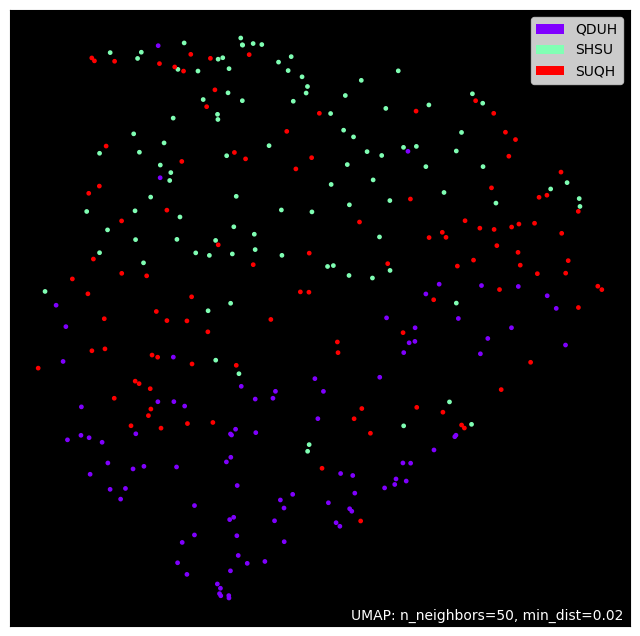

In [19]:
fig = plt.figure(figsize=(10, 10), dpi=100)
umap.plot.points(mapper, 
                 labels=np.array(labels), 
                 theme='fire')